In [ ]:
# Imports

import os
import re
import gzip
import pandas as pd
import numpy as np

# Data Container and Analysis
import anndata as ad
import scanpy as sc
import squidpy as sq

# Machine Learning and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

# CellPLM
from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline

# Environment Configuration (CUDA check)
import torch
if not torch.cuda.is_available():
    torch_load_old = torch.load
    def torch_load_cpu(*args, **kwargs):
        kwargs['map_location'] = torch.device('cpu')
        return torch_load_old(*args, **kwargs)
    torch.load = torch_load_cpu
    print("Running on CPU mode (CUDA not available).")

Running on CPU mode (CUDA not available).


### 1. Gene Expression Data Loading and Merging  

This section loads all spatial transcriptomics files and merges them into one unified gene expression matrix for better downstream analysis.  

The dataset is provided as multiple files, each representing a separate **Visium spatial transcriptomics slide**. Each slide captures **RNA expression patterns** across a thin physical **tissue section**.

These RNA expression patterns show which genes are active and how strongly in different parts of the tissue,  since when a cell uses a gene, it produces mRNA copies of it, *that* is gene expression.

With this technique, RNA molecules released from the tissue bind to barcoded capture spots printed on the slide.  
Each spot records which genes were expressed, basically turning the slide into a grid of thousands of tiny RNA "sensors".  

Because each Visium slide can only capture a limited physical area, the process must be repeated for new sections of tissue, so the dataset comes as multiple files, one for each physical slide (or tissue section).  

Each .txt.gz file contains a **gene expression matrix** for its slide:  
- **Rows** represent genes.  
- **Columns** represent spatial spots (barcoded capture locations on the slide).  
- Each value shows how much RNA from that gene was detected at that spot.  

Each file will be loaded as an AnnData object. The cells below will handle file paths, load counts and coordinates, enforce alignment, and create one single AnnData object for the entire multi-sample dataset.

In [5]:
# Load and Inspect Gene Expression Matrices

import os
import pandas as pd
from IPython.display import display

# Configuration
data_dir = "GSE253975_data"

# Check Directory Contents
print(f"Checking Directory: {data_dir}")

try:
    all_files = [f for f in os.listdir(data_dir) if not f.startswith('.')]
    print(f"Total files found: {len(all_files)}")
    print(all_files)
    
    # Filter only for matrix text files
    txt_files = [f for f in all_files if f.endswith('.txt.gz')]
    print(f"Txt files found: {len(txt_files)}")
    print(txt_files)
    
    if not txt_files:
        print("No .txt.gz files found.")
    else:
        # Pick the first file to test
        test_file = txt_files[0]
        print(f"\n Inspecting First File: {test_file}")
        file_path = os.path.join(data_dir, test_file)

        try:
            df = pd.read_csv(file_path, sep=r'\s+', index_col=0, nrows=5, engine='python') # r'\s+' handles single spaces, tabs, or multiple spaces
            
            print(f"Shape: {df.shape}")
            print(f"Columns (First 5): {list(df.columns)[:5]}")
            
            # Display head for visual check
            print("\nHead of data:")
            display(df.head(2))
            
        except Exception as e:
            print(f"Error reading file: {e}")

except FileNotFoundError:
    print(f"Directory '{data_dir}' not found.")

Checking Directory: GSE253975_data
Total files found: 19
['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']
Txt files found: 9
['GSM8031369_T2465.txt.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031365_T4839.txt.gz']

 Inspecting First File: GSM8031369_T2465.txt.gz
Shape: (5, 958)
Columns (First 5): ['

,"""T2465_AAACCGTTCGTCCAGG.1""","""T2465_AAACGAGACGGTTGAT.1""","""T2465_AAACTGCTGGCTCCAA.1""","""T2465_AAAGGCTCTCGCGCCG.1""","""T2465_AAAGGGATGTAGCAAG.1""","""T2465_AAATACCTATAAGCAT.1""","""T2465_AAATCGTGTACCACAA.1""","""T2465_AAATGGTCAATGTGCC.1""","""T2465_AAATTAACGGGTAGCT.1""","""T2465_AAATTTGCGGGTGTGG.1""",...,"""T2465_TTGTAAGGACCTAAGT.1""","""T2465_TTGTAAGGCCAGTTGG.1""","""T2465_TTGTAATCCGTACTCG.1""","""T2465_TTGTCGTTCAGTTACC.1""","""T2465_TTGTGTATGCCACCAA.1""","""T2465_TTGTGTTTCCCGAAAG.1""","""T2465_TTGTTAGCAAATTCGA.1""","""T2465_TTGTTCAGTGTGCTAC.1""","""T2465_TTGTTGTGTGTCAAGA.1""","""T2465_TTGTTTCACATCCAGG.1"""
"""MIR1302-2HG""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""FAM138A""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Load Individual Gene Expression Matrices Into a Combined AnnData Master Expression Matrix

# Extract unique sample IDs for tracking
sample_ids = sorted(list(set([f.split('_')[0] for f in txt_files])))
print(f"Found {len(sample_ids)} samples: {sample_ids}")

adatas = []

for sample in sample_ids:
    # Find the text file for this sample
    sample_file = [f for f in txt_files if f.startswith(sample)][0]
    file_path = os.path.join(data_dir, sample_file)
    
    print(f"Loading expression matrix: {sample_file}...")
    
    try:
        # Load Data
        df_counts = pd.read_csv(file_path, sep=r'\s+', index_col=0, engine='python')
        
        # Create AnnData Object
        # Transpose (.T) is required because AnnData expects Rows=Spots, Cols=Genes
        adata = sc.AnnData(df_counts.T)
        
        if adata.n_obs == 0:
            print(f"Skipping {sample}: Matrix is empty.")
            continue
            
        # Add Metadata so we can split them apart later if needed
        adata.obs['sample_id'] = sample
        
        adatas.append(adata)
        
    except Exception as e:
        print(f"Error loading {sample}: {e}")

# Combine into One Unified Matrix
if adatas:
    # Merge all spots and keeps all genes (outer join)
    adata = ad.concat(adatas, label='batch', keys=sample_ids, join='outer')
    
    # Optimize by converting to sparse matrix
    from scipy import sparse
    if not sparse.issparse(adata.X):
        adata.X = sparse.csr_matrix(adata.X)
            
    print(f"\nMaster Expression Matrix Created!")
    print(f"Total Spots: {adata.n_obs}")
    print(f"Total Genes: {adata.n_vars}")
else:
    print("No valid data loaded.")

Found 9 samples: ['GSM8031361', 'GSM8031362', 'GSM8031363', 'GSM8031364', 'GSM8031365', 'GSM8031366', 'GSM8031367', 'GSM8031368', 'GSM8031369']
Loading expression matrix: GSM8031361_T0081.txt.gz...
Loading expression matrix: GSM8031362_T3870.txt.gz...
Loading expression matrix: GSM8031363_T2791.txt.gz...
Loading expression matrix: GSM8031364_T5498.txt.gz...
Loading expression matrix: GSM8031365_T4839.txt.gz...
Loading expression matrix: GSM8031366_T5359.txt.gz...
Loading expression matrix: GSM8031367_T4424.txt.gz...
Loading expression matrix: GSM8031368_T3799.txt.gz...
Loading expression matrix: GSM8031369_T2465.txt.gz...

Master Expression Matrix Created!
Total Spots: 9989
Total Genes: 36601


### 2. Data Normalization  

This step normalizes raw gene expression counts are made mathematically comparable across all spatial spots and slides.

Each slide can be thought of as its own *small experiment*, which means that the total amount of RNA captured per spot, the **sequencing depth**, will naturally vary.
If one spot has twice as many total reads as another, its raw gene counts will be falsely inflated. 

Normalization corrects for. this by scaling every spot's raw gene counts relative to its total library size, scaling them all up to a common factor (like CP10K)
The log-transform then compresses large numerical differences to make the distrubution of gene counts suitable for linear models like PCA.

In [7]:
# Normalize the Merged Gene Expression Matrix

# Restore raw counts
if "counts" in adata.layers:
    # Raw data was already filtered and saved. Restore the raw data 
    print("Restoring filtered raw counts from adata.layers['counts'] for re-normalization...")
    adata.X = adata.layers["counts"].copy()

    if 'log1p' in adata.uns:
        del adata.uns['log1p']
    
    # The filter steps below are skipped on re-run.
else:
    # First Run Only: Apply filtering and save the structural change 
    
    # Remove genes that are all zero across all spots
    print(f"Genes before filtering: {adata.n_vars}")
    sc.pp.filter_genes(adata, min_cells=1) # 'min_cells=1' removes genes with 0 counts
    print(f"Genes after filtering (non-zero): {adata.n_vars}")
    
    # Save this resulting filtered matrix to the layer for all future re-runs
    print("Saving FILTERED raw counts to adata.layers['counts']...")
    adata.layers["counts"] = adata.X.copy()

# Normalize counts (CP10K)
# Runs on every execution because the code restored the RAW data above
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform
sc.pp.log1p(adata)

# Validation & Visualization
print(f"\nNormalized Matrix Shape: {adata.shape}")

print("\nTop 10 Highest Expressed Genes "
"\n(Visual check to highlight the most actively expressed genes across all spots, allowing visualization of real variation in the data instead of empty zero regions):")
gene_totals = adata.X.sum(axis=0).A1 
# Get indices of the top 10 genes
top_10_indices = np.argsort(gene_totals)[::-1][:10]
top_10_genes = adata.var_names[top_10_indices]

# Display the top 10 genes for the first 5 spots
display(pd.DataFrame(
    adata.X[:5, top_10_indices].toarray(),
    index=adata.obs_names[:5],
    columns=top_10_genes
))

Genes before filtering: 36601
Genes after filtering (non-zero): 24377
Saving FILTERED raw counts to adata.layers['counts']...

Normalized Matrix Shape: (9989, 24377)

Top 10 Highest Expressed Genes 
(Visual check to highlight the most actively expressed genes across all spots, allowing visualization of real variation in the data instead of empty zero regions):


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,"""MT-CO1""","""MT-CO2""","""MT-ND2""","""MT-CO3""","""MT-ND1""","""MT-ATP6""","""MT-ND4""","""MT-ND3""","""MT-CYB""","""MBP"""
"""T0081_AAACGAGACGGTTGAT.1""",5.516871,4.748358,5.625654,5.150930,5.437163,5.304253,5.477811,5.094113,4.827734,2.999016
"""T0081_AAACTGCTGGCTCCAA.1""",5.689521,5.378386,5.411026,5.273538,5.069907,5.196987,5.309722,5.069907,5.273538,2.732947
"""T0081_AAAGGGCAGCTTGAAT.1""",6.672632,6.267799,4.887178,5.980750,6.267799,5.576547,6.959998,4.887178,5.576547,5.576547
"""T0081_AAAGTTGACTCCCGTA.1""",4.855061,5.140794,5.831010,5.362766,5.257926,5.766667,5.257926,5.257926,5.544306,4.169672
"""T0081_AAATACCTATAAGCAT.1""",5.748665,5.599647,5.385423,6.035550,5.385423,5.748665,5.424468,5.163425,5.211942,2.270898


#### 3. Principal Component Analysis (PCA)  

**PCA** is a classical method used to reduce thousands of gene expression values into a smaller set of features, 50 principal components per spatial spot in this analysis. Each principal component captures one of the strongest overall patterns in how genes vary across the tissue.

It works by finding the main directions (or axes) of variation in the data, summarizing the most important patterns while filtering out noise.  

Instead of analazying all 24,000+ genes, **feature selection** can be used to identift the few thousand genes (2000 in this case) that show the biggest biological differences across the spots to give PCA only the high-quality data to work with.

The **highly varaible genes (HVGs)** method is the feature selection method used.

Total Genes before HVG selection: 24377
Selecting 2000 Highly Variable Genes.
Saved unscaled, log-normalized data to adata.layers['normalized'] for CellPLM input.


/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")



PCA Complete. Results stored in adata.obsm['X_pca'].


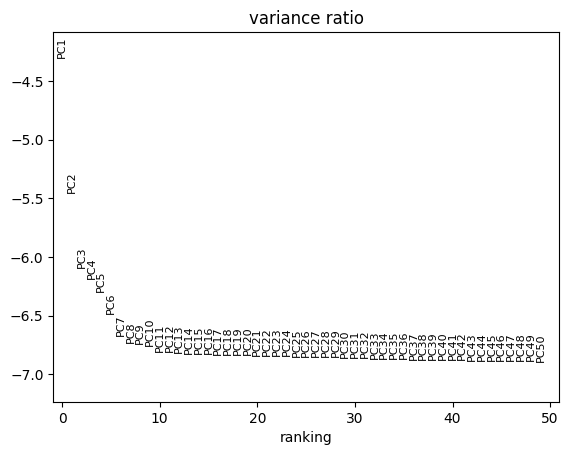

In [8]:
# Feature Selection and Principal Component Analysis

# Identify highly variable genes (HVGs)
print(f"Total Genes before HVG selection: {adata.n_vars}")
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    min_mean=0.0125, 
    max_mean=3, 
    min_disp=0.5,
    # Accunt for technical differences between slides.
    batch_key="batch" 
)
print(f"Selecting {sum(adata.var.highly_variable)} Highly Variable Genes.")

# Save Unscaled Data for CellPLM 
# The data in adata.X is currently log-normalized (correct input for CellPLM)
# Save this perfect state into a layer BEFORE scaling it for PCA.
adata.layers['normalized'] = adata.X.copy()
print("Saved unscaled, log-normalized data to adata.layers['normalized'] for CellPLM input.")

# Scale the data to standardize the variance of each gene (z-score) so that high-expression genes don't dominate the PCA result
sc.pp.scale(adata, max_value=10)

# Run PCA
# The results (the principal components) are stored automatically in adata.obsm['X_pca'].
sc.tl.pca(adata, svd_solver='arpack')

print(f"\nPCA Complete. Results stored in adata.obsm['X_pca'].")

# Validate With an Elbow Plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

The cell bellow aims to correct for the **batch effects** introduced by combining multiple distinct slides.
batch effects are non-biological differences caused by variations in sample preparation, imaging, or techniucal sequencing depth differences.
Although normalization corrected for spot-level sequencing depth variations, **Harmony** is used to correct the remaining *slide-wide* technical bias.
It requies the input to be lower dimensional embeddings, rather than the full gene expression matrix, because processing the full matrix iteratively would be computationally expensive

In [9]:
# Batch Correction

# Run Harmony Integration on PCA Results
# This removes technical batch variation (the 'sample_id'/'batch' key) from the data
sc.external.pp.harmony_integrate(
    adata, 
    key='batch', 
    basis='X_pca' # align the data using the 10 PCs determined by the elbow plot
)

2025-11-23 11:06:40,880 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-23 11:06:41,732 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-23 11:06:41,756 - harmonypy - INFO - Iteration 1 of 10
2025-11-23 11:06:42,441 - harmonypy - INFO - Iteration 2 of 10
2025-11-23 11:06:43,119 - harmonypy - INFO - Converged after 2 iterations


In [10]:
# Compute the Nearest-Neighbor Graph

# This graph is the foundational structure required for UMAP, Leiden, and spatial correlation analysis.
# We use the Harmony-corrected embeddings as input for this structure.
sc.pp.neighbors(
    adata, 
    use_rep='X_pca_harmony', 
    n_neighbors=15 
)

print("Harmony integration and Nearest-Neighbor Graph complete.")

/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


Harmony integration and Nearest-Neighbor Graph complete.


K-Means clustering complete with 7 clusters.


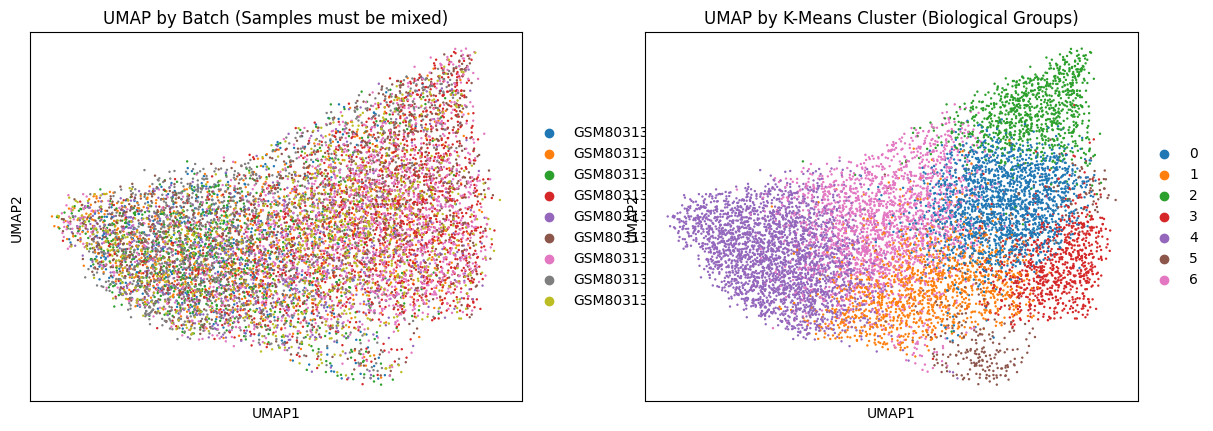

In [11]:
# UMAP Projection, Clustering (K-Means), and Validation Plot

# K-Means Clustering

# Use the top 10 Harmony-corrected PCs as input, based on elbow plot analysis
X_input = adata.obsm['X_pca_harmony'][:, :10] 

n_clusters_to_use = 7 

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=n_clusters_to_use, random_state=0, n_init='auto')

# Store results as categorical strings in the object metadata (adata.obs)
adata.obs['kmeans'] = kmeans.fit_predict(X_input).astype(str) 

print(f"K-Means clustering complete with {n_clusters_to_use} clusters.")

# Run UMAP
# UMAP relies on the Nearest-Neighbor Graph calculated in Cell 6
sc.tl.umap(adata)

# Generate Validation Plot
# This plot validates Harmony (samples should be mixed) and visualizes the K-Means result.
sc.pl.umap(
    adata, 
    color=['batch', 'kmeans'], 
    ncols=2,
    save='_kmeans_harmony_validation.png', 
    title=['UMAP by Batch (Samples must be mixed)', 'UMAP by K-Means Cluster (Biological Groups)']
)

#### Clustering Results and Next Steps

The above scatter plot shows groups of spatial spots with similar transcriptional features, where each dot represents a single spot on the tissue.
Spots are clustered together based on how similar their gene-expression profiles are across thousands of genes.

The next phase will focus on making this data biologically meaningful.
That involves mapping the clusters back to their spatial positions on the original tissue (using the .json metadata) and identifying marker genes, genes that are highly expressed within each cluster.
This can help reveal which parts of the tissue have stronger expression from certain cell types or biological processes.

In the context of the Parkinson’s dataset, this is especially relevant since the original study suggested that localized immune-related gene expression within the tissue may play a key role in the degeneration of neurons.



### 5. Load JSON Files

The provided JSON files contain the spatial metadata for every Visium spot on each slide, including coordinates and whether the spot actually overlaps tissue. Some spots fall on empty areas of the slide and have no meaningful expression data. After loading the JSON files, we keep only the spots marked as tissue=True so downstream analysis focuses on real biological material.

Filtering to tissue-only spots also ensures that the remaining rows line up with the expression matrix, meaning each spatial entry corresponds directly to the same spot in the data.

In [12]:
# Load JSON Files — Spatial Coordinates and Metadata Per Spot

import gzip, json, pandas as pd
from pathlib import Path

data_dir = "GSE253975_data"
print(os.listdir(data_dir))

json_dir = Path(data_dir)
json_files = sorted(json_dir.glob("*.json.gz"))

coords_list = []

for file_path in json_files:
    sample_id = file_path.stem.split("_")[0]  # e.g. GSM8031360
    with gzip.open(file_path, "rt") as f:
        data = json.load(f)
        oligos = pd.DataFrame(data["oligo"])
        oligos["sample_id"] = sample_id
        coords_list.append(oligos)

coords_df = pd.concat(coords_list, ignore_index=True)
coords_df = coords_df.rename(columns={"imageX": "x_coord", "imageY": "y_coord"})

coords_df.head()

['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
0,4825,30073,0,0,53.25297,5938.0490,5803.2710,NaN,GSM8031361
1,4875,30160,1,1,53.25297,5866.8457,5762.1787,NaN,GSM8031361
2,4925,30073,0,2,53.25297,5938.1963,5721.3433,NaN,GSM8031361
3,4975,30160,1,3,53.25297,5866.9937,5680.2510,NaN,GSM8031361
4,5025,30073,0,4,53.25297,5938.3440,5639.4160,NaN,GSM8031361


In [13]:
# Filter out spots that do not actually contain tissue.
# 'tissue=True' marks spots where RNA was captured, so keeping only these
# ensures we work with meaningful spatial data

coords_tissue = coords_df[coords_df["tissue"] == True].copy()

print("Coords Tissue Shape:", coords_tissue.shape)
coords_tissue.head()

Coords Tissue Shape: (9989, 9)


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
1303,5975,31900,21,23,53.25297,4442.9326,4858.4043,True,GSM8031361
1304,6025,31813,20,24,53.25297,4514.2837,4817.5690,True,GSM8031361
1305,6075,31900,21,25,53.25297,4443.0806,4776.4766,True,GSM8031361
1306,6125,31813,20,26,53.25297,4514.4310,4735.6416,True,GSM8031361
1307,6175,31900,21,27,53.25297,4443.2285,4694.5493,True,GSM8031361


In [21]:
# Ensure the number of spots matches exactly before merging
if adata.n_obs != coords_tissue.shape[0]:
    print(f"Mismatch: AnnData has {adata.n_obs} spots, but Coords has {coords_tissue.shape[0]}.")
    print("Please ensure both are sorted by Sample ID before merging.")
else:
    print(f"Spot counts match ({adata.n_obs}). Proceeding with merge...")

    # Assign Spatial Coordinates
    # T ake the x and y image coordinates from the dataframe
    # AnnData expects this as a numpy array in .obsm['spatial']
    adata.obsm['spatial'] = coords_tissue[['x_coord', 'y_coord']].values

    # Add other metadata from the JSONs to adata.obs
    adata.obs['array_row'] = coords_tissue['row'].values
    adata.obs['array_col'] = coords_tissue['col'].values

    print("Spatial coordinates successfully added to adata.obsm['spatial'].")

    # SAVE THE PROCESSED DATA 
    adata.write_h5ad("processed_visium.h5ad")
    print("Saved processed AnnData as processed_visium.h5ad")

Spot counts match (9989). Proceeding with merge...
Spatial coordinates successfully added to adata.obsm['spatial'].
Saved processed AnnData as processed_visium.h5ad


### 6. Align Spatial Coordinates With PCA Data

Now that we have both the spatial coordinates (from the JSON files) and the PCA results (from the expression matrix), they can be brought together. Since the tissue-only spots in the JSON file line up with the columns of the PCA matrix, we can directly attach PCA values to the matching spatial spots. This lets us visualize PCA patterns on the actual tissue layout.


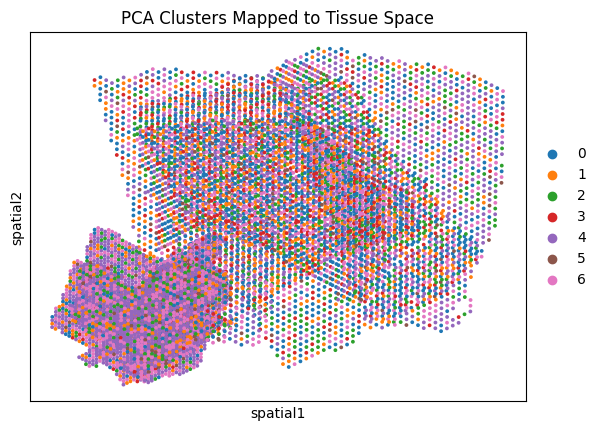

In [17]:
# Spatial Visualization of PCA-Harmony Clusters

# We use 'embedding' with basis='spatial' to plot the coordinates loaded manually.
sc.pl.embedding(
    adata,
    basis="spatial",
    color="kmeans",  # This accesses the clusters from the Harmony/PCA step
    size=30, 
    title="PCA Clusters Mapped to Tissue Space",
    save="_pca_harmony_spatial_map.png"
)

In [16]:
# Identify Marker Genes for PCA-Harmony Clusters
import pandas as pd

# 1. Calculate Marker Genes
print("Finding markers for PCA-Harmony Clusters (kmeans)...")
sc.tl.rank_genes_groups(
    adata, 
    groupby='kmeans', 
    method='wilcoxon', 
    key_added='rank_genes_pca'
)

# 2. Display Top 5 Marker Genes per Cluster
print("\n--- Top 5 Marker Genes (PCA Pathway) ---")
results = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_pca')
top_genes = pd.DataFrame({
    group: results[results['group'] == group]['names'].head(5).values
    for group in results['group'].unique()
})
display(top_genes)

# 3. Check for Parkinson's Marker (TH)
print("\n--- Checking for 'TH' in PCA Clusters ---")
found = False
for group in adata.obs['kmeans'].unique():
    # Get top 50 genes for this cluster
    genes = sc.get.rank_genes_groups_df(adata, group=group, key='rank_genes_pca')['names'].head(50).tolist()
    if 'TH' in genes:
        print(f"✅ Found 'TH' in Cluster {group} (Top 50)")
        found = True
if not found:
    print("❌ 'TH' not found in the top 50 markers of any cluster.")

Finding markers for PCA-Harmony Clusters (kmeans)...

--- Top 5 Marker Genes (PCA Pathway) ---


/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] =

,0,1,2,3,4,5,6
0,"""AQP4""","""PLP1""","""UCHL1""","""PLP1""","""MT-ND2""","""TAGLN""","""MT-CO1"""
1,"""ATP1A2""","""MBP""","""SNAP25""","""SELENOP""","""MBP""","""VIM""","""MT-CO2"""
2,"""SLC1A3""","""SELENOP""","""STMN2""","""TF""","""MT-ND1""","""APOD""","""MT-ND1"""
3,"""CD74""","""TF""","""SYT1""","""APLP1""","""MT-CO1""","""MYL9""","""MT-CYB"""
4,"""MARCKS""","""SPP1""","""THY1""","""CLDND1""","""MT-ATP6""","""IGFBP7""","""MT-CO3"""



--- Checking for 'TH' in PCA Clusters ---
❌ 'TH' not found in the top 50 markers of any cluster.
